In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import libraries
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import (
    col, sum, unix_timestamp, to_date, lit, current_date,
    year, month, dayofweek, hour, sqrt, pow, when, count
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import plotly.graph_objects as go

In [ ]:
# start a spark session
spark = SparkSession.builder.appName('Bank_fraud').getOrCreate()

In [ ]:
fraud_train= spark.read.csv('/content/drive/Othercomputers/My Laptop - Personal/Files/Data_Files/Portfolio Projects/Bank_Fraud_Detection/fraudTrain.csv',
                   header=True, inferSchema=True)
fraud_test = spark.read.csv('/content/drive/Othercomputers/My Laptop - Personal/Files/Data_Files/Portfolio Projects/Bank_Fraud_Detection/fraudTest.csv',
                   header=True, inferSchema=True)
# load train data
fraud_train.show(5)

+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|_c0|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  0|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|     misc_net|  4.97| Jennifer|  Banks|     F|      561 Perry 

In [ ]:
# load test data
fraud_test.show(5)

+---+---------------------+----------------+--------------------+--------------+-----+------+--------+------+--------------------+----------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|_c0|trans_date_trans_time|          cc_num|            merchant|      category|  amt| first|    last|gender|              street|      city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---+---------------------+----------------+--------------------+--------------+-----+------+--------+------+--------------------+----------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  0|  2020-06-21 12:14:25|2291163933867244|fraud_Kirlin and ...| personal_care| 2.86|  Jeff| Elliott|     M|   351 Da

# Data Understanding

In [ ]:
# count the number of rows
print(f'There are {fraud_train.count()} rows in the fraud_train dataset')
print(f'There are {fraud_test.count()} rows in the fraud_test dataset')

There are 1296675 rows in the fraud_train dataset
There are 555719 rows in the fraud_test dataset


In [ ]:
# check duplicates - fraud_train
fraud_train.exceptAll(fraud_train.dropDuplicates()).show()

+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+



In [ ]:
# check duplicates - fraud_test
fraud_test.exceptAll(fraud_test.dropDuplicates()).show()

+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+



In [ ]:
# check schema
print('Schema of fraud_train:')
fraud_train.printSchema()

Schema of fraud_train:
root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [ ]:
# check schema
print('Schema of fraud_test:')
fraud_test.printSchema()

Schema of fraud_test:
root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [ ]:
# check for null values in each column
# cast nulls to int: 1 for null, 0 for non-null. Summarize the count of these values.
print('Null values in fraud_train:')
fraud_train.select([sum(col(c).isNull().cast('int')).alias(c) for c in fraud_train.columns]).show()


Null values in fraud_train:
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|  0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+



In [ ]:
print('Null values in fraud_test:')
fraud_test.select([sum(col(c).isNull().cast('int')).alias(c) for c in fraud_test.columns]).show()

Null values in fraud_test:
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|  0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+



In [ ]:
# check number of unique customers (cc_num) and unique transactions (trans_num) from fraud_train
# count unique customers (cc_num)
unique_customers = fraud_train.select('cc_num').distinct().count()
print(f'Number of unique customers: {unique_customers}')

# count unique transactions (trans_num)
unique_transactions = fraud_train.select('trans_num').distinct().count()
print(f'Number of unique transactions: {unique_transactions}')

Number of unique customers: 983
Number of unique transactions: 1296675


In [ ]:
# filter rows where is_fraud is 0 - Nn-fraudulent transaction
non_fraud = fraud_train.filter(fraud_train['is_fraud'] == 0)
print(f'Number of non-fraudulent transactions: {non_fraud.count()}')

# filter rows where is_fraud is 1 - Fraudulent transaction
fraud = fraud_train.filter(fraud_train['is_fraud'] == 1)
print(f'Number of fraudulent transactions: {fraud.count()}')

Number of non-fraudulent transactions: 1289169
Number of fraudulent transactions: 7506


In [ ]:
# count transactions
non_fraud_count = non_fraud.count()
fraud_count = fraud.count()

# create the bar graph
fig = go.Figure()

# add bars for non-fraud and fraud counts
fig.add_trace(go.Bar(
    x=['Non-Fraudulent Transactions', 'Fraudulent Transactions'],
    y=[non_fraud_count, fraud_count],
    marker_color=['blue', 'red']  # Different colors for clarity
))

# customize layout
fig.update_layout(
    title='Fraud vs Non-Fraud Transactions',
    xaxis_title='Transaction Type',
    yaxis_title='Count',
    template='plotly_white',
)

# Show the plot
fig.show()


- Fraud cases are 7506 in number, making that 0.5% iof the total transaction. The data is extremely imbalnced

In [ ]:
#  plot for Transaction Amount Distribution
# Filter for fraud cases only
fraud_cases = fraud_test.filter(col('is_fraud') == 1)

# convert the fraud cases to a Pandas DataFrame
fraud_cases_pd = fraud_cases.select('amt').toPandas()

# create the plot for fraud cases' transaction amounts
fig_fraud_amt = go.Figure(
    go.Histogram(
        x=fraud_cases_pd['amt'],
        nbinsx=30,  # You can adjust the number of bins
        marker_color='red',
        name='Fraud Transaction Amount'
    )
)

# Update layout for the plot
fig_fraud_amt.update_layout(
    title_text='Transaction Amounts for Fraud Cases',
    xaxis_title='Transaction Amount',
    yaxis_title='Count',
    template='plotly_white'
)

# Show the plot
fig_fraud_amt.show()


**Insights:**

Common Fraud Strategy:
- Alot of fraud cases are between 0-400. This could be to avoid detection and could involve card fraud in small purchases.
- Less common cases are above 600.

In [ ]:
# Top 20 Cities with Fraud Cases
# Group by city and count the number of fraud cases in each city
fraud_by_city = fraud_cases.groupBy('city').count().toPandas()

# Sort by the count in descending order and select the top 20 cities
top_20_cities = fraud_by_city.sort_values(by='count', ascending=False).head(20)

# create the bar plot for fraud cases by city (top 20 cities)
fig_fraud_city_top_20 = go.Figure(
    go.Bar(
        x=top_20_cities['city'],
        y=top_20_cities['count'],
        marker_color='red',
        name='Fraud Cases by City'
    )
)

# Update layout for the plot
fig_fraud_city_top_20.update_layout(
    title_text='Top 20 Cities with Fraud Cases',
    xaxis_title='City',
    yaxis_title='Number of Fraud Cases',
    template='plotly_white',
    xaxis_tickangle=-45  # Rotates x-axis labels if necessary
)

# Show the plot
fig_fraud_city_top_20.show()

- The fraud cases are generally evenly distributed across cities but a higher number in Camden and Birmingham.

In [ ]:
# Fraud Transaction Volume by Hour
# Extract the hour from the transaction date and time
fraud_cases_with_hour = fraud_cases.withColumn('hour', hour(fraud_cases['trans_date_trans_time']))

# Group by hour and count the number of fraud cases for each hour
fraud_by_hour = fraud_cases_with_hour.groupBy('hour').count().toPandas()

# create the bar plot for fraud transaction volume by hour
fig_fraud_time_bar = go.Figure(
    go.Bar(
        x=fraud_by_hour['hour'],  # Time (hour)
        y=fraud_by_hour['count'],  # Number of fraud cases
        marker=dict(color='red'),
        name='Fraud Cases by Hour'
    )
)

# Update layout for the plot
fig_fraud_time_bar.update_layout(
    title_text='Fraud Transaction Volume by Hour',
    xaxis_title='Hour of the Day',
    yaxis_title='Number of Fraud Cases',
    template='plotly_white'
)

# Show the plot
fig_fraud_time_bar.show()

- Fraud cases seem to happen throughout the day, but more in the evening to right after midnight

# Data Cleaning
- Rename the columns for better understanding
  - `first` to `first_name`
  - `last` to `last_name`
  - `city_pop` to `city_population`
  - `dob` to `date_of_birth`


In [ ]:
# rename the columns for both train and test datasets
# train dataset
fraud_train = fraud_train.withColumnRenamed('first', 'first_name') \
                         .withColumnRenamed('last', 'last_name') \
                         .withColumnRenamed('city_pop', 'city_population') \
                         .withColumnRenamed('dob', 'date_of_birth')

# test dataset
fraud_test = fraud_test.withColumnRenamed('first', 'first_name') \
                       .withColumnRenamed('last', 'last_name') \
                       .withColumnRenamed('city_pop', 'city_population') \
                       .withColumnRenamed('dob', 'date_of_birth')

# Verify the columns were dropped
fraud_train.printSchema()
fraud_test.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_population: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- date_of_birth: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp 

# Feature Engineering

- Add the `age` column derived from date_of_birth
- Create `transaction_hour` and `transaction_day`, `transaction_month`
- Add a distance in kilometres column `distance_cust_to_merch(km)`
- Drop columns that are not needed in the modelling

  - `_c0`
  - `cc_num`
  - `trans_num`
  - `unix_time`
  - `first_name`
  - `last_name`
  - `street`

In [ ]:
# create 'age' column from 'date_of_birth'
fraud_train = fraud_train.withColumn('age', year(current_date()) - year(col('date_of_birth')))
fraud_test = fraud_test.withColumn('age', year(current_date()) - year(col('date_of_birth')))

# create 'transaction_hour' and 'transaction_day', 'transaction_month'
# train dataset
fraud_train = fraud_train.withColumn('transaction_month', month(col('trans_date_trans_time')))
fraud_train = fraud_train.withColumn('transaction_hour', hour(col('trans_date_trans_time')))
fraud_train = fraud_train.withColumn('transaction_day', dayofweek(col('trans_date_trans_time')))

# test dataset
fraud_test = fraud_test.withColumn('transaction_month', month(col('trans_date_trans_time')))
fraud_test = fraud_test.withColumn('transaction_hour', hour(col('trans_date_trans_time')))
fraud_test = fraud_test.withColumn('transaction_day', dayofweek(col('trans_date_trans_time')))

# calculate distance between customer and merchant in km. 111 is usied to get the estimate distance
# train dataset
fraud_train = fraud_train.withColumn(
    'distance_cust_to_merch(km)',
    sqrt(pow(col('lat') - col('merch_lat'), 2) + pow(col('long') - col('merch_long'), 2)) * 111)
# test dataset
fraud_test = fraud_test.withColumn(
    'distance_cust_to_merch(km)',
    sqrt(pow(col('lat') - col('merch_lat'), 2) + pow(col('long') - col('merch_long'), 2)) * 111)

# drop unnecessary columns
fraud_train = fraud_train.drop('_c0', 'cc_num', 'trans_num', 'unix_time',
                               'first_name', 'last_name', 'street')
fraud_test = fraud_test.drop('_c0', 'cc_num', 'trans_num', 'unix_time',
                             'first_name', 'last_name', 'street')

# Verify updated data
fraud_train.show(5)
fraud_test.show(5)

+---------------------+--------------------+-------------+------+------+--------------+-----+-----+-------+---------+---------------+--------------------+-------------+------------------+-----------+--------+---+-----------------+----------------+---------------+--------------------------+
|trans_date_trans_time|            merchant|     category|   amt|gender|          city|state|  zip|    lat|     long|city_population|                 job|date_of_birth|         merch_lat| merch_long|is_fraud|age|transaction_month|transaction_hour|transaction_day|distance_cust_to_merch(km)|
+---------------------+--------------------+-------------+------+------+--------------+-----+-----+-------+---------+---------------+--------------------+-------------+------------------+-----------+--------+---+-----------------+----------------+---------------+--------------------------+
|  2019-01-01 00:00:18|fraud_Rippin, Kub...|     misc_net|  4.97|     F|Moravian Falls|   NC|28654|36.0788| -81.1781|          

In [ ]:
# view age distribution for fraud cases
# Filter for fraud and non-fraud cases from fraud_train
non_fraud_cases = fraud_train.filter(col('is_fraud') == 0)
fraud_cases = fraud_train.filter(col('is_fraud') == 1)

# convert both fraud and non-fraud cases to Pandas DataFrames
non_fraud_cases_pd = non_fraud_cases.select('age').toPandas()
fraud_cases_pd = fraud_cases.select('age').toPandas()

# create the first plot for fraud cases
fig_fraud = go.Figure(
    go.Histogram(
        x=fraud_cases_pd['age'],
        nbinsx=20,
        marker_color='red',
        name='Fraud Cases'
    )
)

fig_fraud.update_layout(
    title_text='Age Distribution for Fraud Cases',
    xaxis_title='Age (years)',
    yaxis_title='Count',
    template='plotly_white'
)
fig_fraud.show()

# create the second plot for non-fraud cases
fig_non_fraud = go.Figure(
    go.Histogram(
        x=non_fraud_cases_pd['age'],
        nbinsx=20,
        marker_color='blue',
        name='Non-Fraud Cases'
    )
)

fig_non_fraud.update_layout(
    title_text='Age Distribution for Non-Fraud Cases',
    xaxis_title='Age (years)',
    yaxis_title='Count',
    template='plotly_white'
)
fig_non_fraud.show()


Output hidden; open in https://colab.research.google.com to view.

**Insights:**
- Non-fraud cases
  - Most transactions are between 30 and 60 years throught to 80 years. Majority are working class and retirees
  - There are also transactions made by 90 and 100 year olds too.
- Fraud cases
  - Alot of these are between 30 and 60 to 90 year olds. These are of course the target victims.

In [ ]:
# check schema
fraud_train.printSchema()
fraud_test.printSchema()

root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_population: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- date_of_birth: date (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- transaction_month: integer (nullable = true)
 |-- transaction_hour: integer (nullable = true)
 |-- transaction_day: integer (nullable = true)
 |-- distance_cust_to_merch(km): double (nullable = true)

root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category

In [ ]:
# drop the 'trans_date_trans_time' column in both fraud_train and fraud_test datasets
fraud_train = fraud_train.drop('trans_date_trans_time')
fraud_test = fraud_test.drop('trans_date_trans_time')

# Data Encoding
- Get the correlation between each features and the 'is_fraud' column. Use VectorAssembler to combine the features into a single vector column `new_features` before calculating the correlations using the *stat.corr* function where handles the case where a `features` column might already exist.

In [ ]:
# define the list of features
features = ['amt', 'city_population', 'age', 'transaction_month', 'transaction_hour',
            'transaction_day', 'distance_cust_to_merch(km)']

# initialize fraud_train_transformed if not defined
fraud_train_transformed = fraud_train

# drop the existing 'features' column if it exists
fraud_train_transformed = fraud_train_transformed.drop('features')

# assemble features into a new vector column
assembler = VectorAssembler(inputCols=features, outputCol='new_features')
fraud_train_transformed = assembler.transform(fraud_train_transformed)

# compute correlations between each feature and 'is_fraud'
for feature in features:
    correlation = fraud_train_transformed.stat.corr(feature, 'is_fraud')
    print(f'Correlation between {feature} and is_fraud: {correlation}')


Correlation between amt and is_fraud: 0.21940388895887128
Correlation between city_population and is_fraud: 0.0021359024181982463
Correlation between age and is_fraud: 0.012378101674716485
Correlation between transaction_month and is_fraud: -0.012409331585155019
Correlation between transaction_hour and is_fraud: 0.01379937052344759
Correlation between transaction_day and is_fraud: 0.009620213899482673
Correlation between distance_cust_to_merch(km) and is_fraud: 0.00043417047602957134


Set up a pipeline for feature encoding in Spark. Handle the categorical features by using *StringIndexer* and *OneHotEncoder* to convert them into numerical representations.

In [ ]:
# only encode the 'city' column
indexer = StringIndexer(inputCol='city', outputCol='city_index', handleInvalid='skip')
encoder = OneHotEncoder(inputCol='city_index', outputCol='city_onehot')

# numerical columns remain unchanged
numerical_columns = ['amt', 'city_population', 'age', 'transaction_month', 'transaction_hour',
                      'transaction_day', 'distance_cust_to_merch(km)']

# assemble stages for the pipeline
stages = [indexer, encoder]

# create pipeline
pipeline = Pipeline(stages=stages)

Scale the numerical features using StandardScaler after assembling them into a vector. Then combine the encoded categorical features with the scaled features into a final `features` vector using another VectorAssembler.

# Feature Scaling

In [ ]:
# feature scaling
# assemble only the 'city' one-hot encoded feature
categorical_assembler = VectorAssembler(
    inputCols=['city_onehot'], outputCol='categorical_features'
)

# assemble numerical features
numerical_assembler = VectorAssembler(
    inputCols=numerical_columns, outputCol='numerical_features'
)

# StandardScaler for scaling numerical features
scaler = StandardScaler(
    inputCol='numerical_features', outputCol='scaled_numerical_features',
    withMean=True, withStd=True
)

# final assembler to combine both categorical and scaled numerical features
final_assembler = VectorAssembler(
    inputCols=['categorical_features', 'scaled_numerical_features'], outputCol='features'
)

# create the pipeline
pipeline = Pipeline(stages=[indexer, encoder, numerical_assembler, scaler, categorical_assembler, final_assembler])

# fit and transform the data
pipeline_model = pipeline.fit(fraud_train)
fraud_train_transformed = pipeline_model.transform(fraud_train)
fraud_test_transformed = pipeline_model.transform(fraud_test)

Address class imbalance in the training data by creating a new column, `class_weight`, assigning a higher weight (5.0) to instances where is_fraud is 1 (fraudulent transactions) and a lower weight (1.0) to instances where is_fraud is 0 (non-fraudulent transactions). This weighting scheme will be used during model training to give more importance to the minority (fraudulent) class.

## Handling class imbalance
 - Calculate weights based on the class distribution

In [ ]:
# calculate class distribution
total_count = fraud_train_transformed.count()
fraud_count = fraud_train_transformed.filter(col('is_fraud') == 1).count()
non_fraud_count = fraud_train_transformed.filter(col('is_fraud') == 0).count()

# calculate weights for both minority and majority classes
fraud_weight = total_count / (2 * fraud_count)
non_fraud_weight = total_count / (2 * non_fraud_count)

# assign dynamic weights normalized between classes
fraud_train_transformed = fraud_train_transformed.withColumn(
    'class_weight',
    when(col('is_fraud') == 1, lit(fraud_weight)).otherwise(lit(non_fraud_weight))
)
# print the class weights
print(f'Fraud Weight: {fraud_weight}')
print(f'Non-Fraud Weight: {non_fraud_weight}')

Fraud Weight: 86.37589928057554
Non-Fraud Weight: 0.5029111776656126


# Modelling
Create a RandomForestClassifier model using the prepared training data (fraud_train_transformed).  It specifies the `features` column, the `is_fraud` column, and uses the `class_weight` column to handle the class imbalance during training.

In [ ]:
# model Training
# Train a RandomForest model with class weights
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='is_fraud',
    weightCol='class_weight',
    numTrees=100,
    maxDepth=8,
    maxBins=32,
    minInstancesPerNode=2,
    impurity='entropy',  # or 'entropy'
    featureSubsetStrategy='auto'
)

# fit the model
rf_model = rf.fit(fraud_train_transformed)
rf_model

RandomForestClassificationModel: uid=RandomForestClassifier_b5c12db07a00, numTrees=100, numClasses=2, numFeatures=900

## Evaluate the model

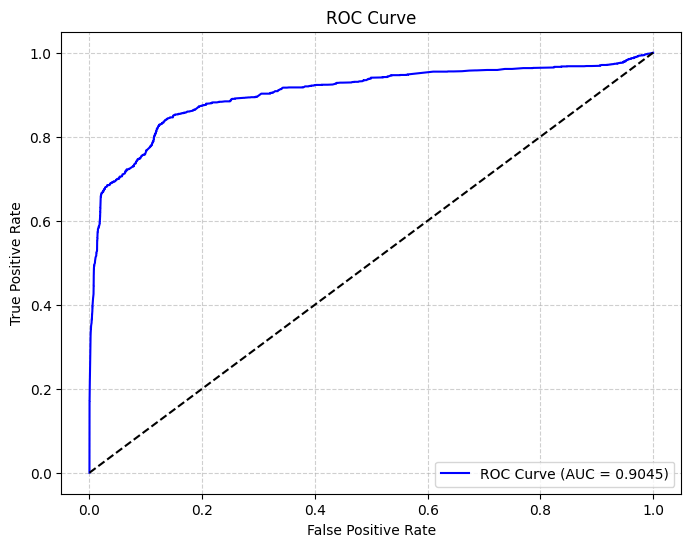

In [ ]:
# evaluate the model using AUC
predictions = rf_model.transform(fraud_test_transformed)
binary_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud',
                                                 rawPredictionCol='probability',
                                                 metricName='areaUnderROC')
auc = binary_evaluator.evaluate(predictions)

# extract probabilities and labels for ROC curve plotting
probabilities = np.array(predictions.select('probability').rdd.map(lambda row: row[0][1]).collect())
labels = np.array(predictions.select('is_fraud').rdd.map(lambda row: row[0]).collect())

# plot the ROC curve
fpr, tpr, _ = roc_curve(labels, probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# evaluate further

# add a column to indicate prediction correctness
confusion_df = predictions.withColumn(
    'confusion',
    when((col('is_fraud') == 1) & (col('prediction') == 1), 'TP').
    when((col('is_fraud') == 0) & (col('prediction') == 1), 'FP').
    when((col('is_fraud') == 0) & (col('prediction') == 0), 'TN').
    when((col('is_fraud') == 1) & (col('prediction') == 0), 'FN')
)

# count each category
confusion_counts = confusion_df.groupBy('confusion').count().collect()
confusion_dict = {row['confusion']: row['count'] for row in confusion_counts}

# extract TP, FP, TN, FN
TP = confusion_dict.get('TP', 0)
FP = confusion_dict.get('FP', 0)
TN = confusion_dict.get('TN', 0)
FN = confusion_dict.get('FN', 0)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}')

Precision : 0.05267702936096719
Recall : 0.694210786739238
TP: 1403, FP: 25231, TN: 528343, FN: 618


In [ ]:
# stop the Spark session
spark.stop()

**Insights:**

Confusion Matrix Summary

- **True Positives (TP):** 1,403 — Correct fraud predictions
- **False Positives (FP):** 25,231 — Non-fraud cases incorrectly predicted as fraud
- **True Negatives (TN):** 528,343 — Correct non-fraud predictions
- **False Negatives (FN):** 618 — Fraud cases missed by the model
- **Recall:** 68.8% -  The model detects fraud cases moderately.
- A low Precision of 5.6% indicates that a significant number of non-fraud cases are falsely flagged as fraud.


# Conclusion
The Random Forest classifier demonstrated moderate recall (68.8%), successfully identifying most fraudulent transactions. However, precision was low (5.6%), indicating a significant number of false fraud flags. This trade-off suggests that while the model is good at catching fraudulent cases along with legitimate ones, it requires further tuning to minimize disruptions from false alerts.

# Recommendation
Given the high cost of false positives in financial operations, adjusting the decision threshold or implementing cost-sensitive evaluation strategies would be essential to balance the model's performance. For production-level deployment, closer collaboration with domain experts and further refinement of feature engineering techniques are recommended to improve precision.